In [1]:
# Create folder named experiment#1 in processed data, outputs and analysis

# Get data for flow, tessellations, demographics and geographical boundary of WA

# Split data into training and test - create four files: Flows for train and test, region indices for train and test
# Save these files in processed data folder 
# Create visualization and save to outputs of experiement

# Biased sampling on the training data to create two biased datasets - save in processed data folder for experiment1 

# Run single constrained gravity model on biased training data and original data to create three models 
# Run trained models on unbiased test data and create generated flows in outputs 

# Use generated flows from outputs and test true labels from processed data to create fairness metrics and visualizations
# Save this in outputs - fairness.json and fairness.png (for each model)

In [1]:
import sys
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

experiment_id = '1'

Tessellation crs is epsg:4326
Tessellation crs is epsg:4326


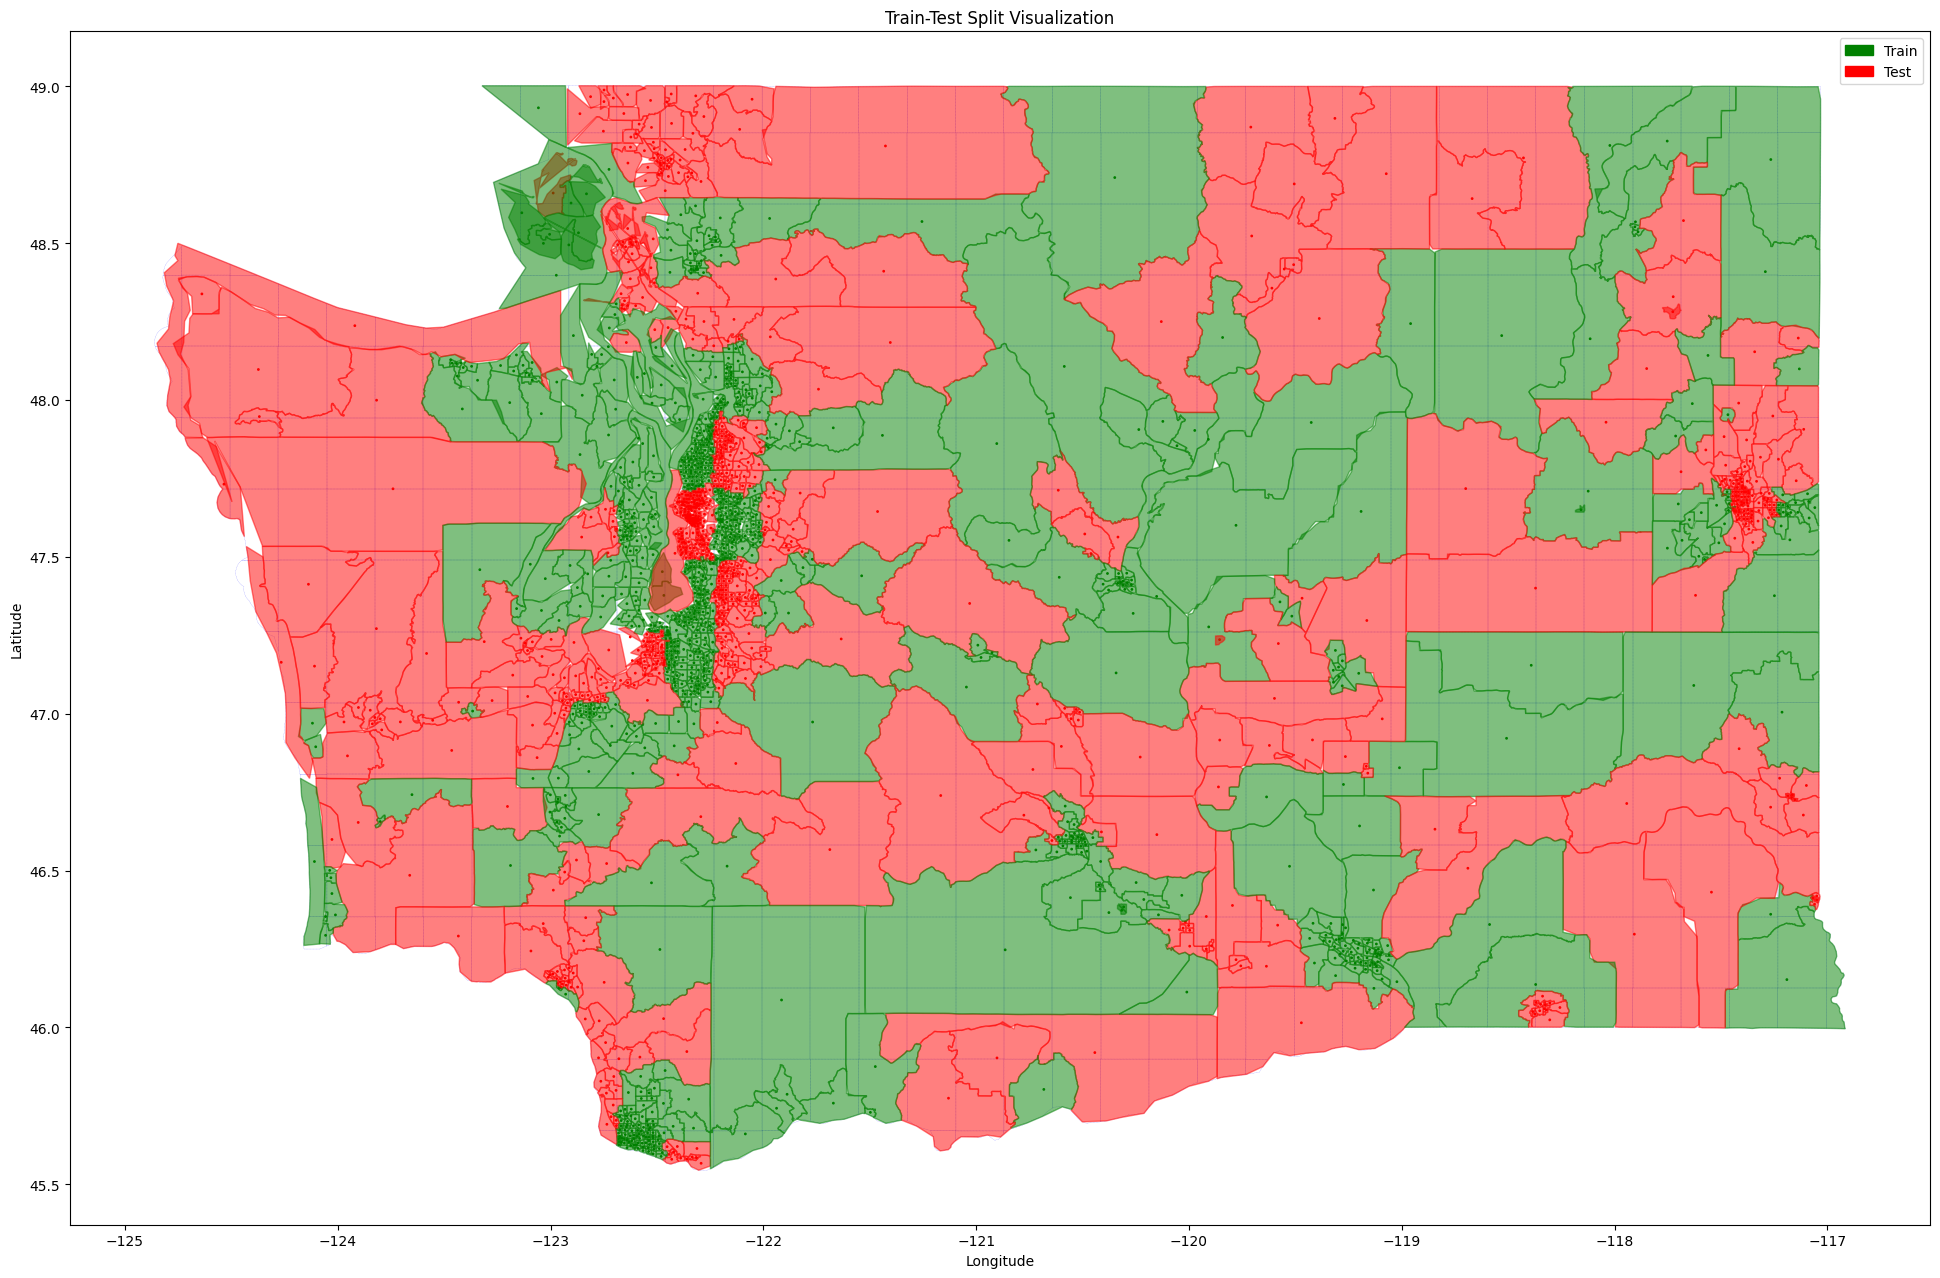

/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed and saved all datasets successfully.
Missing geoids tessellation have been saved to ../processed_data/1/diagnosis_split_missing/missing_geoids_tessellation.csv.


In [2]:
# Split the data into train and test sets

sys.path.append(os.path.abspath('../preprocessing'))
from train_test_processing import *
sys.path.append(os.path.abspath('../preprocessing'))
from train_test_split_vis import *
sys.path.append(os.path.abspath('../utils'))
from crs_conversion import *

washington = load_state_or_county_data('../data/WA/boundary.geojson')
flow_df = pd.read_csv('../data/WA/flow.csv')
features_df = pd.read_csv('../data/WA/features.csv')

# convert_crs_epsg('../data/WA/tessellation_wpop.geojson', '../data/WA/tessellation_wpop_new.geojson', 2927, 4326)
tessellation_df = load_state_or_county_data('../data/WA/tessellation_wpop_new.geojson')

grid = create_grid(washington.unary_union, 25)
train_output, test_output = flow_train_test_split(tessellation_df, features_df, grid, experiment_id = experiment_id)
plot_grid_and_census_tracts(tessellation_df, grid, train_output, test_output, experiment_id = experiment_id)
filter_train_test_data(flow_df, tessellation_df, features_df, train_output, test_output, experiment_id = experiment_id)

In [3]:
# Biased sampling train flow data

sys.path.append(os.path.abspath('../preprocessing'))
from biased_sampling import *

features_df = pd.read_csv('../processed_data/1/train/train_features.csv')
train_flows_df = pd.read_csv('../processed_data/1/train/flows/train_flow.csv')
demographics_df = pd.read_csv('../data/WA/demographics.csv')


calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=1, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='ascending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)
calculate_biased_flow(features_df, demographics_df, train_flows_df, demographic_column_name='svi', method=2, order='descending', sampling=False, experiment_id=experiment_id, bias_factor=0.5)

/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.
Saved adjusted flows to ../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/1_descending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv.
Missing train sampling flow diagnostic saved to ../processed_data/1/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/1/train/flows/svi/2_descending_biased_flow.csv.


In [7]:
# Fit gravity model

sys.path.append(os.path.abspath('../models'))
from gravity import *

tessellation_train = gpd.read_file('../processed_data/1/train/train_tessellation.geojson')
tessellation_test = gpd.read_file('../processed_data/1/test/test_tessellation.geojson')

# gravity_0 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/train_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

In [5]:
gravity_1 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Inte

100%|██████████| 628/628 [00:00<00:00, 1928.51it/s]
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apple/opt/anaconda3/envs/pycharm_crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [8]:
gravity_2 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/1_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1605.08it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [9]:
gravity_3 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_ascending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1545.71it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [12]:
gravity_4 = grav_Model(tessellation_train, tessellation_test, '../processed_data/1/train/flows/svi/2_descending_biased_flow.csv', '../processed_data/1/test/flows/test_flow.csv', 'gravity_singly_constrained', 'flows')

Model fitting starts...
Model fitting completed.


100%|██████████| 628/628 [00:00<00:00, 1597.46it/s]
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:298: RuntimeWarning: invalid value encountered in multiply
  trip_probs_matrix = trip_probs_matrix * relevances_dest ** self.destination_exp * \
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


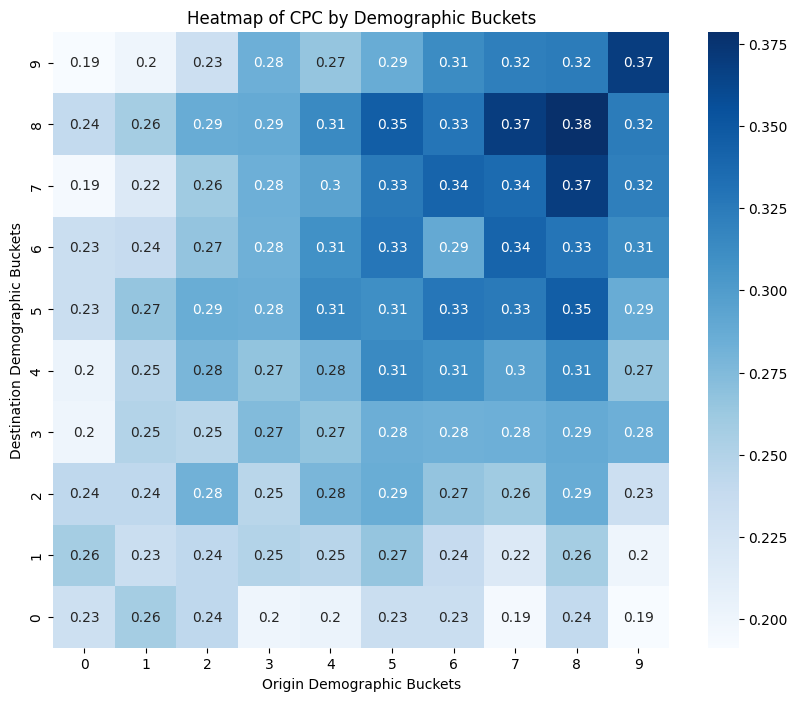

Fairness Metric (kl_divergence of CPC): 0.01337703138804307
Overall CPC: 0.2863387810579544


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../evaluation'))
from eval import FlowEvaluator

flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/train_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

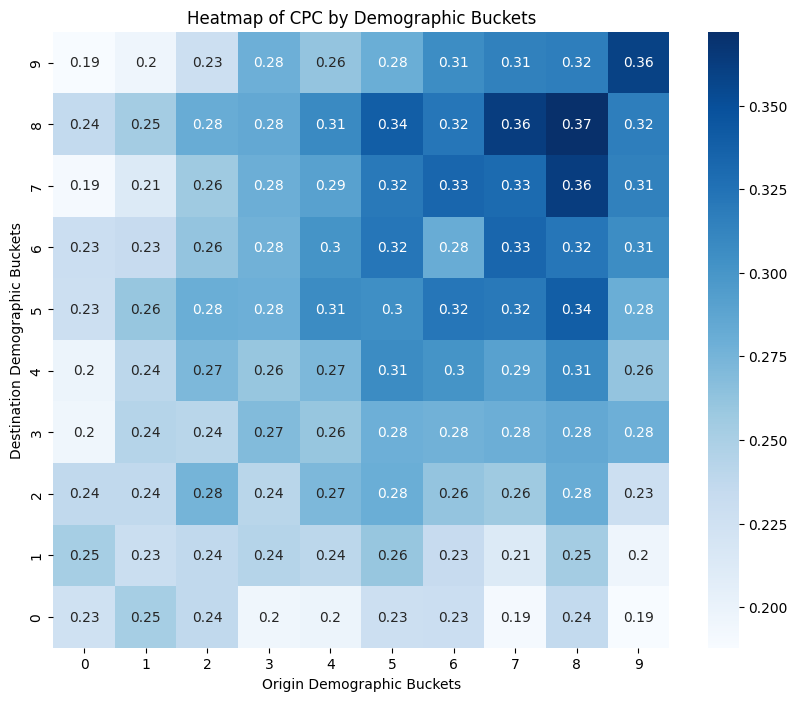

Fairness Metric (kl_divergence of CPC): 0.013421956054325196
Overall CPC: 0.28055797524645765


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../evaluation'))
from eval import FlowEvaluator

flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/1_ascending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

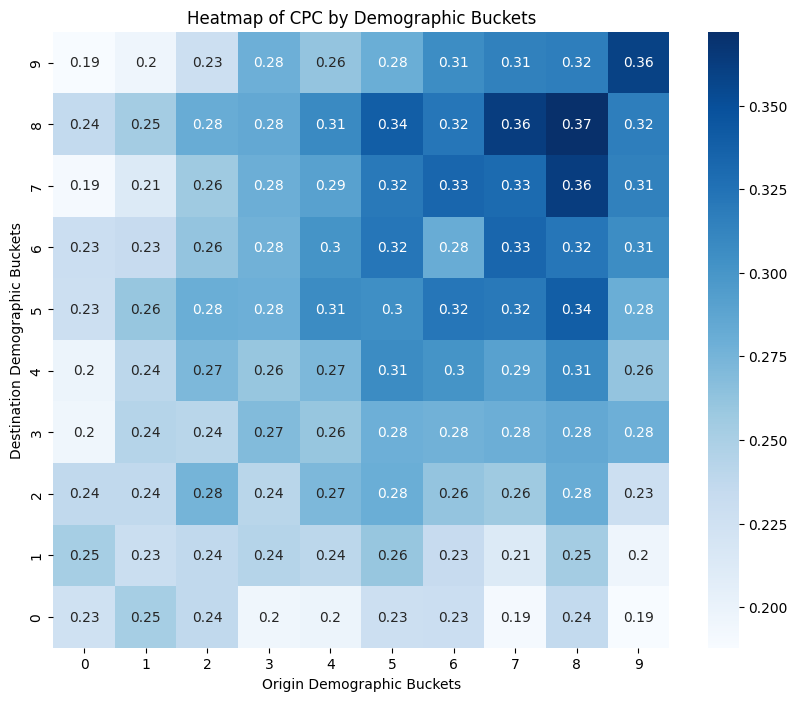

Fairness Metric (kl_divergence of CPC): 0.013421956054325208
Overall CPC: 0.2805579752464571


In [10]:
import sys
import os
sys.path.append(os.path.abspath('../evaluation'))
from eval import FlowEvaluator

flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/2_ascending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

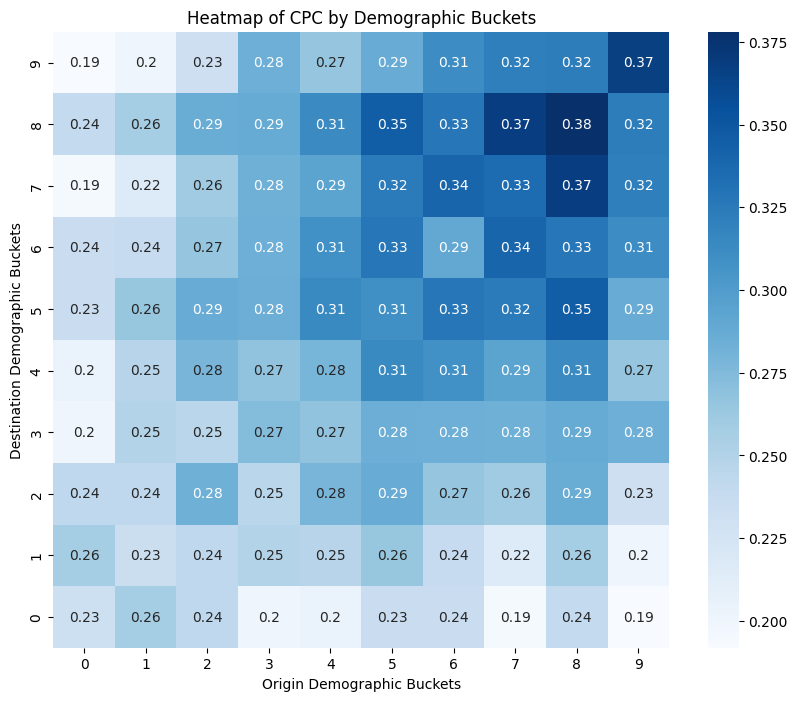

Fairness Metric (kl_divergence of CPC): 0.01311374832710344
Overall CPC: 0.2861760388498589


In [11]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/1_descending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

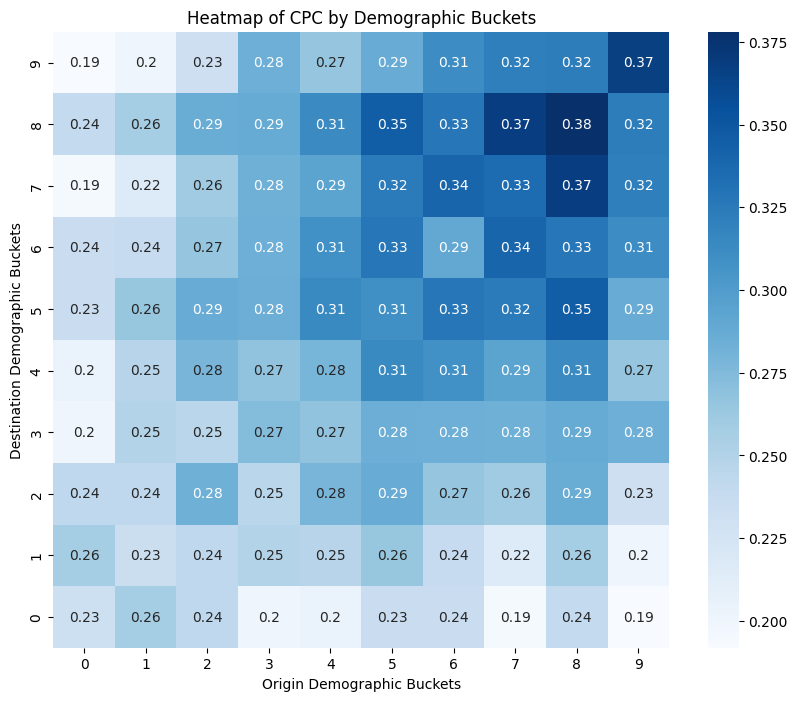

Fairness Metric (kl_divergence of CPC): 0.01311374832710344
Overall CPC: 0.2861760388498589


In [4]:
flows_path = '../processed_data/1/test/flows/test_flow.csv'
generated_flows_path = '../outputs/1/synthetic_data_gravity_singly_constrained/svi/2_descending_biased_flow.csv' # TODO change accordingly
demographics_path = '../data/WA/demographics.csv'
demographic_column = 'svi'
evaluator = FlowEvaluator(flows_path, generated_flows_path, demographics_path)
fairness = evaluator.evaluate_fairness(accuracy_metric='CPC', variance_metric='kl_divergence', demographic_column=demographic_column)

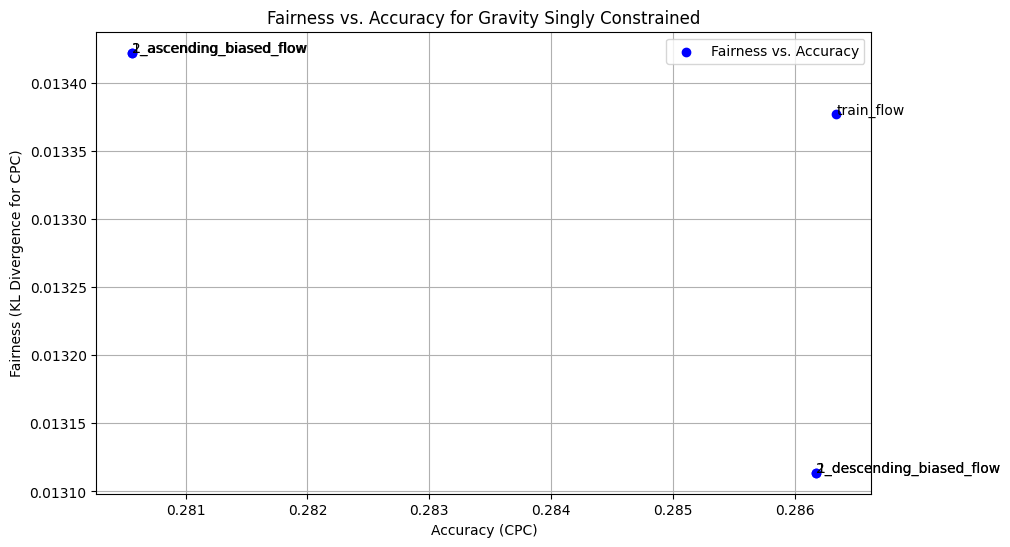

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv("/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/outputs/1/results/results.csv")
fairness = results['fairness_kl_divergence_CPC']
accuracy = results['accuracy_CPC']

plt.figure(figsize=(10, 6))
plt.scatter(accuracy, fairness, color='blue', label='Fairness vs. Accuracy')
plt.xlabel('Accuracy (CPC)')
plt.ylabel('Fairness (KL Divergence for CPC)')
plt.title('Fairness vs. Accuracy for Gravity Singly Constrained')
for i, txt in enumerate(results['data']):
    plt.annotate(txt, (accuracy[i], fairness[i]))
plt.legend()
plt.grid(True)
plt.show()


In [6]:
results

,data,model,fairness_kl_divergence_CPC,accuracy_CPC
0,train_flow,gravity_singly_constrained,0.013377,0.286339
1,1_ascending_biased_flow,gravity_singly_constrained,0.013422,0.280558
2,1_descending_biased_flow,gravity_singly_constrained,0.013114,0.286176
3,2_ascending_biased_flow,gravity_singly_constrained,0.013422,0.280558
4,2_descending_biased_flow,gravity_singly_constrained,0.013114,0.286176


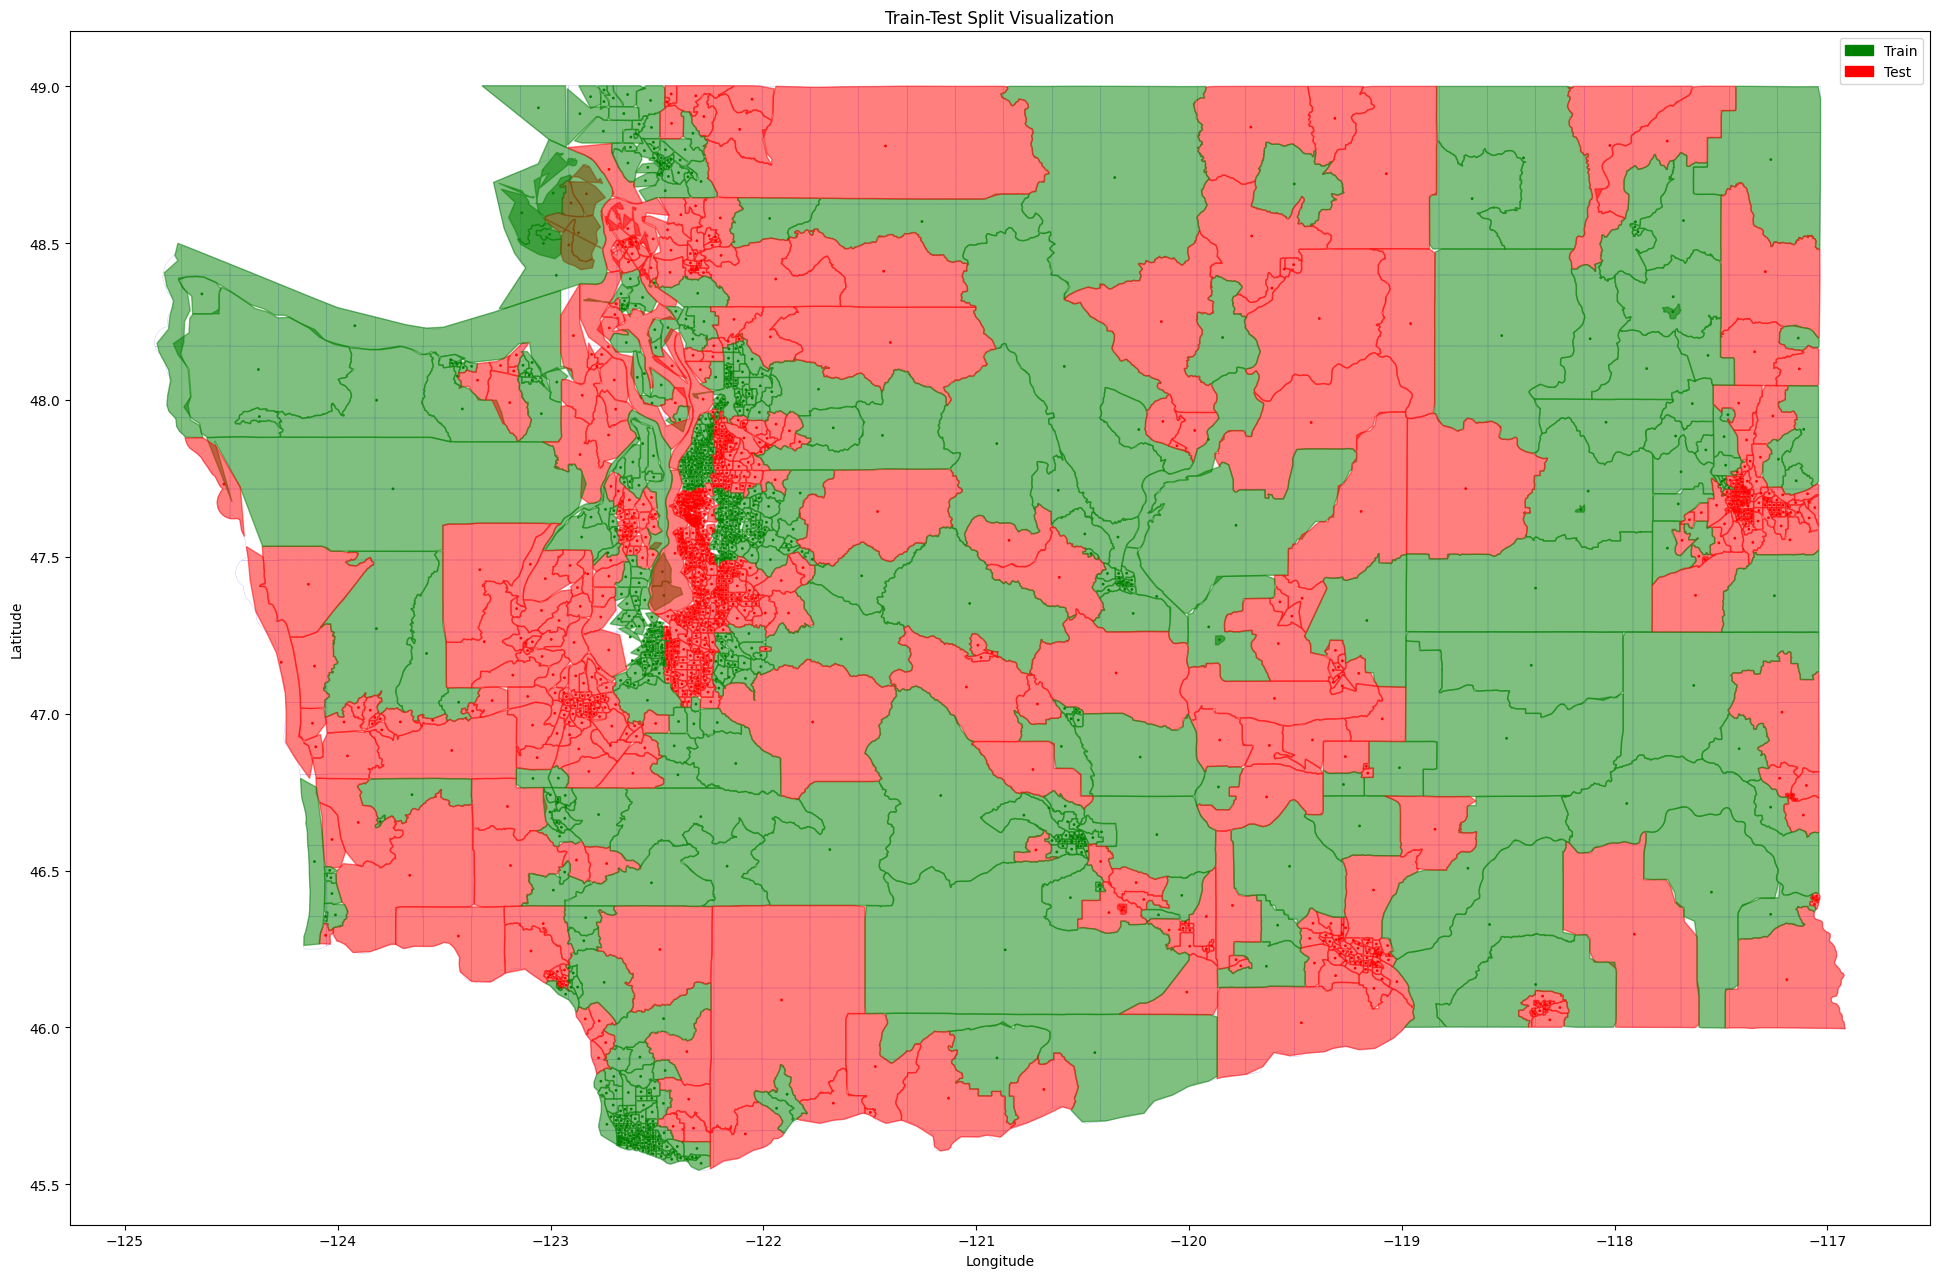

/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/apoorvasheera/anaconda3/envs/crowdflow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed and saved all datasets successfully.
Missing geoids tessellation have been saved to ../processed_data/2/diagnosis_split_missing/missing_geoids_tessellation.csv.
Missing train sampling flow diagnostic saved to ../processed_data/2/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/2/train/flows/svi/1_ascending_sampled_flow_0.csv.
Missing train sampling flow diagnostic saved to ../processed_data/2/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/2/train/flows/svi/1_descending_sampled_flow_0.csv.
Missing train sampling flow diagnostic saved to ../processed_data/2/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/2/train/flows/svi/2_ascending_sampled_flow_0.csv.
Missing train sampling flow diagnostic saved to ../processed_data/2/train/diagnosis_sampling_missing/missing_flow.csv.


/Users/apoorvasheera/Documents/DSSG/Crowd Flow/branches/crowdflow-fairness/preprocessing/biased_sampling.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geoid_x'} in the result is deprecated and will raise a MergeError in a future version.
  destination_merge = pd.merge(destination_merge, features_df[['geoid', 'total_population']], how='left', left_on='destination', right_on='geoid')


Saved adjusted flows to ../processed_data/2/train/flows/svi/2_descending_sampled_flow_0.csv.
Running model: ../processed_data/2/train/flows/train_flow.csv
Model fitting starts...


KeyboardInterrupt: 

In [1]:
from experiments import * 
main()

In [4]:
import geopandas as gpd 

sys.path.append(os.path.abspath('../models'))
from gravity import *

train_flow_path = f"../processed_data/2/train/flows/train_flow.csv"
test_flow_path = f"../processed_data/2/test/flows/test_flow.csv"
tessellation_train = gpd.read_file(f"../processed_data/2/train/train_tessellation.geojson")
tessellation_test = gpd.read_file(f"../processed_data/2/test/test_tessellation.geojson")
gravity_5 = grav_Model(tessellation_train, tessellation_test, train_flow_path, test_flow_path, 'gravity_singly_constrained', 'flows')

Model fitting starts...
